In [1]:
# подключаем нужные библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import warnings
warnings.filterwarnings('ignore')

# Линейная регрессия

## Для начала посмотрим на наши данные, чтобы выбрать подходящие переменные

In [2]:
# посмотрим на наши данные
df = pd.read_excel('index2022_data.xlsx')
df.head()

,CountryID,CountryName,HighIncome,Income,Development,Region,WorldRank,RegionRank,2022Score,PropertyRights,...,GovernmentExpenditurofGDP,Population,GDP,GDP_GrowthRate,5Year_GDP_GrowthRate,GDPperCapita,Unemployment,Inflation,FDIInflow,PublicDebt
0,1,Afghanistan,0,low income,developing,Asia-Pacific,NaN,NaN,NaN,NaN,...,NaN,38.928341,78.729,-5.000,0.9824,2390.024,11.73,5.607,13.0,7.785
1,2,Albania,0,middle income,developing,Europe,50.0,30.0,66.6,55.5,...,30.514667,2.837743,40.737,-3.500,1.9856,14218.106,11.70,1.603,1107.0,75.960
2,3,Algeria,0,middle income,developing,Middle East and North Africa,167.0,13.0,45.8,27.9,...,37.827000,43.851043,491.459,-5.992,0.1016,11112.187,12.83,2.415,1125.0,53.067
3,4,Angola,0,middle income,developing,Sub-Saharan Africa,139.0,29.0,52.6,39.8,...,21.255000,32.866268,215.105,-3.975,-1.8610,6931.862,7.70,22.277,-1866.0,127.115
4,5,Argentina,0,middle income,developing,Americas,144.0,27.0,50.1,35.1,...,39.581333,45.376763,941.848,-9.956,-2.7740,20750.990,11.67,42.015,4123.0,102.998


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CountryID                  184 non-null    int64  
 1   CountryName                184 non-null    object 
 2   HighIncome                 184 non-null    int64  
 3   Income                     184 non-null    object 
 4   Development                184 non-null    object 
 5   Region                     184 non-null    object 
 6   WorldRank                  177 non-null    float64
 7   RegionRank                 177 non-null    float64
 8   2022Score                  177 non-null    float64
 9   PropertyRights             177 non-null    float64
 10  JudicialEffectiveness      177 non-null    float64
 11  GovernmentIntegrity        177 non-null    float64
 12  TaxBurden                  177 non-null    float64
 13  GovernmentSpending         177 non-null    float64

In [4]:
# Названия переменных, скруппированные по типам данных
for t in df.dtypes.unique():
     print('Type: {}\n{}\n'.format(t, df.dtypes[df.dtypes==t].index.values))

# из обжектов можно выбрать категориальные переменные, из интов и флоатов номинальные

Type: int64
['CountryID' 'HighIncome']

Type: object
['CountryName' 'Income' 'Development' 'Region']

Type: float64
['WorldRank' 'RegionRank' '2022Score' 'PropertyRights'
 'JudicialEffectiveness' 'GovernmentIntegrity' 'TaxBurden'
 'GovernmentSpending' 'FiscalHealth' 'BusinessFreedom' 'LaborFreedom'
 'MonetaryFreedom' 'TradeFreedom' 'InvestmentFreedom' 'FinancialFreedom'
 'TariffRate' 'IncomeTaxRate' 'CorporateTaxRate' 'TaxBurdenofGDP'
 'GovernmentExpenditurofGDP' 'Population' 'GDP' 'GDP_GrowthRate'
 '5Year_GDP_GrowthRate' 'GDPperCapita' 'Unemployment' 'Inflation'
 'FDIInflow' 'PublicDebt']



In [5]:
# Процент пропущенных значений по переменным, содержащим пропуски
missing = (df.isna().sum() / len(df)) * 100
missing = missing[missing > 0].sort_values(ascending=False)
missing = pd.DataFrame({'Процент пропущенных значений' : missing})
missing
# тут всё хорошово, проценты небольшие

,Процент пропущенных значений
TariffRate,4.347826
WorldRank,3.804348
BusinessFreedom,3.804348
GovernmentExpenditurofGDP,3.804348
RegionRank,3.804348
InvestmentFreedom,3.804348
TradeFreedom,3.804348
MonetaryFreedom,3.804348
LaborFreedom,3.804348
FinancialFreedom,3.804348


## Выбор переменных
- Зависимая переменная - `InvestmentFreedom`: Индекс свободы инвестиций (чем меньше в стране ограничений на приток инвестиционного капитала, тем выше значение переменной)
- Независимые переменные:
`HighIncome`, `Development`, `Region` + не менее 5 метрических переменных, имеющих самую высокую корреляцию с переменной `InvestmentFreedom`

`Region` и `HighIncome` - категориальные перемененные, поэтому нужно добавить dummy-переменные для них

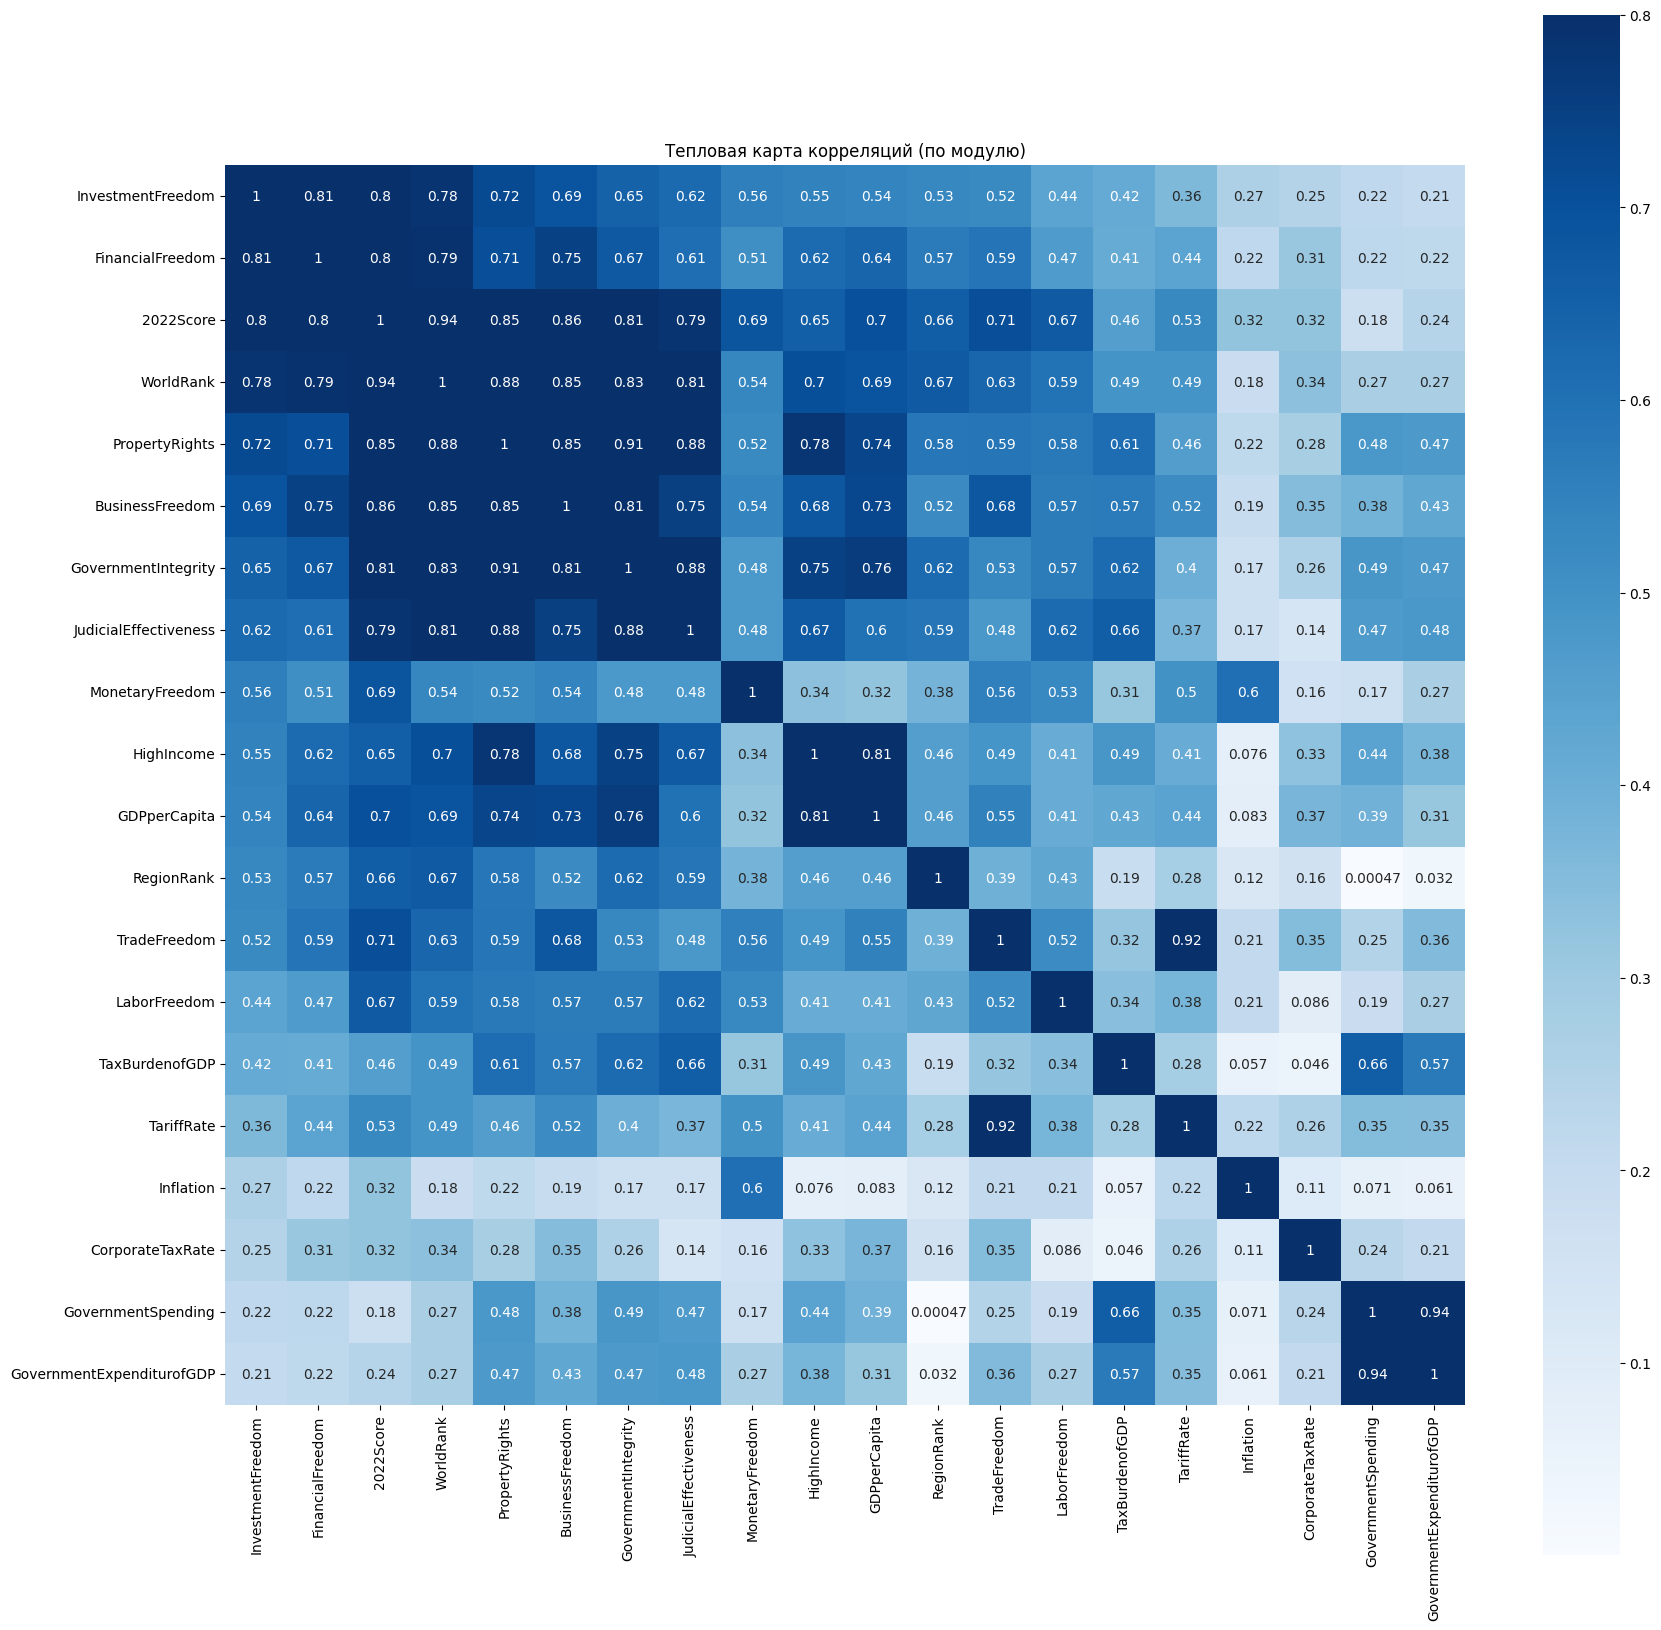

In [6]:
# Все корреляции
corr = df.corr(numeric_only=True)

# Будем рассматривать модули коэффициентов корреляции
corr_abs = corr.abs()

# Определяем топ-20 переменных с наибольшей корреляцией с InvestmentFreedom
top_corr_features = corr_abs['InvestmentFreedom'].nlargest(20).index
top_corr_matrix_abs = corr_abs.loc[top_corr_features, top_corr_features]

# Построение тепловой карты
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr_matrix_abs, annot=True, square=True, cmap='Blues', vmax=0.8)
plt.title('Тепловая карта корреляций (по модулю)')
plt.show()


многие переменные коррелируют друг с другом, а нам нужно выбрать такие, которые будут  сильно коррелировать с зависимой и не сильно друг с другом

- давайте возьмём `FinancialFreedom`, она очень сильно коррелирует с `2022Score`, `WorldRank`, ..., поэтому их не будем брать
- Возьмём `JudicialEffectiveness`, у них не такая большая корреляция с `FinancialFreedom`
- Возьмём `MonetaryFreedom`
- `GDPperCapita` не берём ввиду высокой корреляции с HighIncome
- Возьмём `RegionRank`
- Возьмём `TradeFreedom`


In [7]:
# табличку сделаем
cols = ['InvestmentFreedom', 'FinancialFreedom', 'JudicialEffectiveness', 'MonetaryFreedom', 'RegionRank', 'TradeFreedom']
df[cols].corr()

,InvestmentFreedom,FinancialFreedom,JudicialEffectiveness,MonetaryFreedom,RegionRank,TradeFreedom
InvestmentFreedom,1.000000,0.810863,0.624804,0.558407,-0.533869,0.522745
FinancialFreedom,0.810863,1.000000,0.609096,0.506973,-0.571700,0.589607
JudicialEffectiveness,0.624804,0.609096,1.000000,0.475688,-0.586951,0.480105
MonetaryFreedom,0.558407,0.506973,0.475688,1.000000,-0.381038,0.556261
RegionRank,-0.533869,-0.571700,-0.586951,-0.381038,1.000000,-0.392887
TradeFreedom,0.522745,0.589607,0.480105,0.556261,-0.392887,1.000000


dummy-переменные для категориальных предикторов

In [8]:
df['Region'].value_counts()
# выбросов нет

Region
Sub-Saharan Africa              48
Europe                          46
Asia-Pacific                    40
Americas                        32
Middle East and North Africa    18
Name: count, dtype: int64

In [9]:
Region_dummies=pd.get_dummies(df.Region, prefix='Region', prefix_sep='_', dtype=int, drop_first=True)
Region_dummies.head(50)
df = pd.concat([df, Region_dummies], axis=1)
# df

In [10]:
df['Development'].value_counts()
# выбросов нет

Development
developing    145
developed      39
Name: count, dtype: int64

In [11]:
Development_dummies=pd.get_dummies(df.Development, prefix='Development', prefix_sep='_', dtype=int, drop_first=True)
Development_dummies.head(50)
df = pd.concat([df, Development_dummies], axis=1)
df

,CountryID,CountryName,HighIncome,Income,Development,Region,WorldRank,RegionRank,2022Score,PropertyRights,...,GDPperCapita,Unemployment,Inflation,FDIInflow,PublicDebt,Region_Asia-Pacific,Region_Europe,Region_Middle East and North Africa,Region_Sub-Saharan Africa,Development_developing
0,1,Afghanistan,0,low income,developing,Asia-Pacific,NaN,NaN,NaN,NaN,...,2390.024,11.73,5.607,13.000000,7.785,1,0,0,0,1
1,2,Albania,0,middle income,developing,Europe,50.0,30.0,66.6,55.5,...,14218.106,11.70,1.603,1107.000000,75.960,0,1,0,0,1
2,3,Algeria,0,middle income,developing,Middle East and North Africa,167.0,13.0,45.8,27.9,...,11112.187,12.83,2.415,1125.000000,53.067,0,0,1,0,1
3,4,Angola,0,middle income,developing,Sub-Saharan Africa,139.0,29.0,52.6,39.8,...,6931.862,7.70,22.277,-1866.000000,127.115,0,0,0,1,1
4,5,Argentina,0,middle income,developing,Americas,144.0,27.0,50.1,35.1,...,20750.990,11.67,42.015,4123.000000,102.998,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,182,Zambia,0,middle income,developing,Sub-Saharan Africa,154.0,36.0,48.7,38.3,...,3341.987,12.17,16.350,234.000000,117.761,0,0,0,1,1
180,183,Zimbabwe,0,middle income,developing,Sub-Saharan Africa,173.0,46.0,33.1,20.8,...,2621.820,5.70,557.210,194.000000,88.873,0,0,0,1,1
181,184,Somalia,0,low income,developing,Sub-Saharan Africa,NaN,NaN,NaN,NaN,...,924.532,13.10,NaN,464.000000,NaN,0,0,0,1,1
182,185,Kosovo,0,middle income,developing,Europe,86.0,40.0,60.1,47.4,...,11274.282,NaN,0.168,304.225999,24.414,0,1,0,0,1


Гипотезы исследования:
- H0: FinancialFreedom влияет на зависимую переменную
- H1: JudicialEffectiveness влияет на зависимую переменную
- H2: 'MonetaryFreedom' влияет на зависимую переменную
- H3: 'RegionRank' влияет на зависимую переменную
- H4: TradeFreedom влияет на зависимую переменную
гипотезы H5-H9 - соответствующиме переменные не влияют на зависимую

<font color='red'> в консе говорил, как формулировать гипотезы</font>

Построим модель линейной регрессии

In [12]:
import statsmodels.api as sm

cols = ['FinancialFreedom', 'JudicialEffectiveness', 'MonetaryFreedom', 'RegionRank',
        'TradeFreedom', 'Region_Asia-Pacific', 'Region_Europe', 'Region_Middle East and North Africa',
        'Region_Sub-Saharan Africa', 'Development_developing']

# уберем null'ы и построим модель
df_model = df.dropna(subset=cols + ['InvestmentFreedom'])
x_mult = df_model[cols]
y = df_model['InvestmentFreedom']
x_mult_constant = sm.add_constant(x_mult)
model = sm.OLS(y, x_mult_constant).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      InvestmentFreedom   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     51.93
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           5.82e-46
Time:                        20:43:01   Log-Likelihood:                -662.27
No. Observations:                 177   AIC:                             1347.
Df Residuals:                     166   BIC:                             1381.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### Уравнение регрессии

In [13]:
l = []
for (param, index) in zip(model.params[1:], model.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))

print('Y = {:2f} + {}'.format(model.params[0], ' + '.join(l)))

Y = 14.896752 + 0.57*FinancialFreedom + 0.05*JudicialEffectiveness + 0.25*MonetaryFreedom + -0.39*RegionRank + -0.04*TradeFreedom + -8.53*Region_Asia-Pacific + 9.60*Region_Europe + -9.19*Region_Middle East and North Africa + 0.51*Region_Sub-Saharan Africa + 4.91*Development_developing


### Оценка модели в целом
- R^2=0.758: 75.8% дисперсии зависимой переменной InvestmentFreedom объясняется предикторами. Это высокий показатель, что свидетельствует о хорошей подгонке модели.
- Adj. R^2=0.743: Указывает на высокую объяснительную силу модели, скорректированную на количество предикторов.
- F-statistic = 51.93, Prob(F-statistic) = 5.82e-46: Показатель F-критерия указывает, что модель статистически значима в целом (гипотезы H5-H9 отвергаются).

### Оценка статистической значимости регрессионных коэффициентов


In [14]:
f'Статистически значимые параметры модели: {model.pvalues[model.pvalues < 0.05].index.values}'

"Статистически значимые параметры модели: ['FinancialFreedom' 'MonetaryFreedom' 'RegionRank' 'Region_Asia-Pacific'\n 'Region_Europe' 'Region_Middle East and North Africa']"

In [15]:
f'Статистически не значимые параметры модели: {model.pvalues[model.pvalues > 0.05].index.values}'

"Статистически не значимые параметры модели: ['const' 'JudicialEffectiveness' 'TradeFreedom'\n 'Region_Sub-Saharan Africa' 'Development_developing']"

Только значимые предикторы следует учитывать для интерпретации. Незначимые переменные можно исключить из модели.

### Сравнение по силе взаимосвязи
- Самый сильный положительный предиктор: FinancialFreedom (коэф=0.573).
- Самый сильный отрицательный предиктор: Region_Asia-Pacific (коэф=−8.534).

### Интерпретация взаимосвязей
Количественные предикторы:
- FinancialFreedom (coef=0.573, p < 0.001): Увеличение финансовой свободы на единицу связано с ростом инвестиционной свободы на 0.573 единицы.
- MonetaryFreedom (coef=0.250, p = 0.001): Рост денежной свободы способствует увеличению инвестиционной свободы, но влияние слабее, чем у FinancialFreedom.
- RegionRank (coef=−0.395, p = 0.002): Более низкое ранжирование региона связано с увеличением инвестиционной свободы.

Категориальные предикторы (dummy-переменные):
- Region_Asia-Pacific (coef=−8.534, p = 0.001): У стран региона Азии и Тихого океана уровень инвестиционной свободы на 8.534 ниже базовой группы (вероятно, Америка).
- Region_Europe (coef=9.598, p = 0.007): У стран Европы уровень инвестиционной свободы на 9.598 выше базовой группы.
- Region_Middle East and North Africa (coef=−9.185, p = 0.018): У стран этого региона инвестиционная свобода значительно ниже базовой группы.
- Region_Sub-Saharan Africa (coef=0.507, p = 0.844): Влияние незначимо.

<font color='red'> что значит "вероятно"?</font>

## Диагностика модели

P-value: 0.423


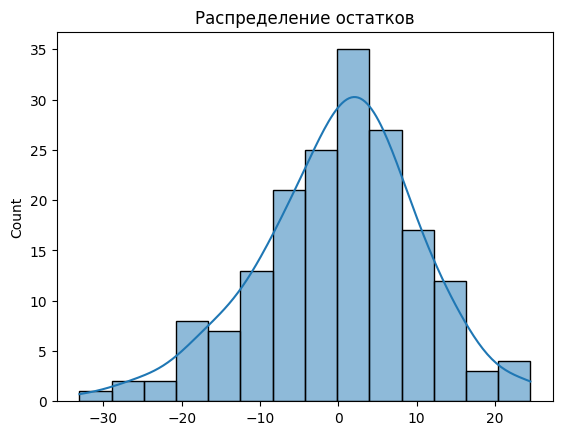

In [16]:
# Проверка на нормальность распределения остатков
p = stats.kstest(model.resid, 'norm', args=(model.resid.mean(), model.resid.std())).pvalue
print(f'P-value: {p:.3f}')

# График распределения остатков
sns.histplot(model.resid, kde=True)
plt.title("Распределение остатков")
plt.show()
# Если p-значение меньше 0.05, то распределение остатков отличается от нормального
# => распределение остатков нормально

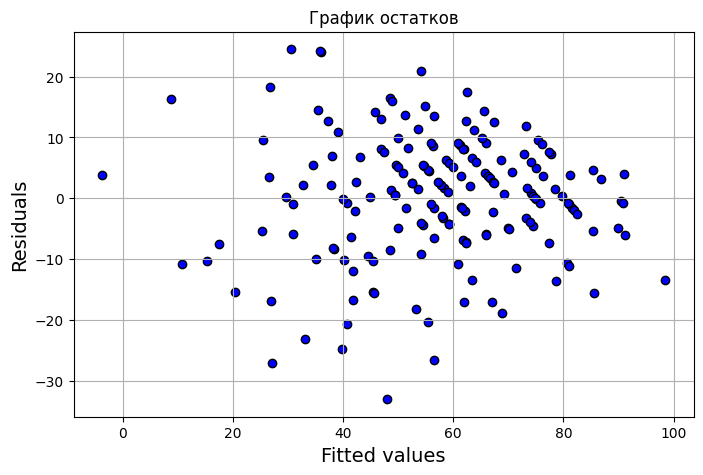

In [17]:
# Проверка гетероскедастичности
plt.figure(figsize=(8,5))
plt.scatter(x=model.fittedvalues, y=model.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title("График остатков")
plt.show()

In [18]:
# Проверка мультиколлинеарности
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Вычисление VIF для каждого признака
vifs = np.array([vif(model.model.exog, i) for i in range(model.model.exog.shape[1])])
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model.params.index[1:]
vif_df = vif_df.sort_values(by=['VIF'])
print(vif_df)

# Нет значений VIF, превышающих 10. Проблема мультиколлинеарности отсутствует

        VIF                             Features
2  1.697894                      MonetaryFreedom
7  1.710566  Region_Middle East and North Africa
5  1.852485                  Region_Asia-Pacific
8  2.050628            Region_Sub-Saharan Africa
4  2.136342                         TradeFreedom
0  2.868447                     FinancialFreedom
9  3.084352               Development_developing
6  3.750390                        Region_Europe
3  3.755679                           RegionRank
1  3.971885                JudicialEffectiveness


-  VIF для всех переменных находятся в пределах нормы (< 10), что указывает на отсутствие проблемы мультиколлинеарности в модели. Это означает, что предикторы не имеют сильной корреляции между собой, и их взаимная зависимость не влияет существенно на точность оценок регрессионных коэффициентов. Наибольшие значения VIF наблюдаются у переменных JudicialEffectiveness (3.97) и  RegionRank (3.756), но они все еще находятся в пределах допустимого диапазона. Это свидетельствует о том, что мультиколлинеарность не оказывает значительного влияния на модель, и все предикторы могут быть использованы без риска искажения их воздействия на зависимую переменную.

In [19]:
# Проверка на выбросы и влияющие наблюдения
influence = model.get_influence()
inf_sum = influence.summary_frame()
inf_sum = inf_sum.reset_index()

# потенциальные влияющие наблюдения
inf_sum['dffits'][(inf_sum['dffits'] > 1) | (inf_sum['dffits'] < -1)].sort_values()

# потенциальные выбросы
inf_sum['standard_resid'][(inf_sum['standard_resid'] > 3) | (inf_sum['standard_resid'] < -3)].sort_values()

17   -3.208989
Name: standard_resid, dtype: float64

<font color='red'> показала бы или описала, что за наблюдения такие</font>

### Подтверждение гипотез
- H0: FinancialFreedom влияет на зависимую переменную
  - Подтверждена. p<0.001, coef=0.573: FinancialFreedom оказывает сильное положительное влияние на InvestmentFreedom. Это ожидаемо, так как эффективная банковская система и свобода финансового сектора способствуют инвестиционной привлекательности страны.
- H1: JudicialEffectiveness влияет на зависимую переменную
  - Не подтверждена. p=0.366, coef=0.054: Индекс эффективности правовой системы не имеет значимого влияния на инвестиционную свободу. Этот результат может быть неожиданным, так как сильная правовая система часто рассматривается как один из факторов инвестиционной привлекательности.
- H1: JudicialEffectiveness влияет на зависимую переменную
  - Не подтверждена. p=0.366, coef=0.054: Индекс эффективности правовой системы не имеет значимого влияния на инвестиционную свободу. Этот результат может быть неожиданным, так как сильная правовая система часто рассматривается как один из факторов инвестиционной привлекательности.
- H2: MonetaryFreedom влияет на зависимую переменную
  - Подтверждена. p=0.001, coef=0.250: Свобода денежной политики оказывает значительное положительное влияние на InvestmentFreedom. Это логично, поскольку стабильная денежная политика снижает барьеры для иностранных инвесторов.
- H3: RegionRank влияет на зависимую переменную
  - Подтверждена. p=0.002, coef=-0.395: Чем выше региональное ранжирование страны (хуже позиция), тем ниже уровень инвестиционной свободы. Это также ожидаемо, так как более развитые и конкурентоспособные регионы обеспечивают благоприятные условия для инвестиций.
- H4: TradeFreedom влияет на зависимую переменную
  - Не подтверждена. p=0.636, coef=−0.042: Индекс свободы торговли не оказывает значимого влияния на инвестиционную свободу. Это может быть неожиданным, так как снижение барьеров торговли часто связано с увеличением притока инвестиций.


#### Ожидаемые результаты
- FinancialFreedom как ключевой фактор: Это было предсказуемо, так как независимость финансового сектора и его эффективность напрямую влияют на инвестиционную свободу.
- Свобода денежной политики (MonetaryFreedom): Тесная связь между монетарной стабильностью и инвестициями также логична.

#### Неожиданные результаты
- JudicialEffectiveness не влияет: Этот результат неожиданный, так как эффективность правовой системы обычно считается важным фактором для защиты инвесторов и регулирования рынка.
- TradeFreedom незначим: Свобода торговли в данном анализе оказалась слабым предиктором. Это может быть связано с тем, что инвестиционная свобода более зависит от финансовых и институциональных факторов, чем от торговли.
- Регионы как важный фактор: Региональные различия оказались более значимыми, чем такие количественные индексы, как налоговая нагрузка или торговая свобода. - Особенно заметно влияние региона Asia-Pacific (отрицательное) и Europe (положительное), что подчеркивает различия в инвестиционных климатах.

### Итог
Модель выявила ключевые факторы, влияющие на инвестиционную свободу: FinancialFreedom, MonetaryFreedom, RegionRank, и региональные dummy-переменные. Большинство результатов оказались ожидаемыми.

# Кластерный анализ

InvestmentFreedom + не менее 5 метрических переменных, корреляция которых с переменной InvestmentFreedom, не превышает 0,5

In [20]:
# перед началом выполнения подключим нужные библиотеки

import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import warnings
warnings.filterwarnings("ignore")

Заново прочитаем данные, чтобы не было добавленных dummy-переменных

In [21]:
# посмотрим на наши данные
df = pd.read_excel('index2022_data.xlsx')
df.head()

,CountryID,CountryName,HighIncome,Income,Development,Region,WorldRank,RegionRank,2022Score,PropertyRights,...,GovernmentExpenditurofGDP,Population,GDP,GDP_GrowthRate,5Year_GDP_GrowthRate,GDPperCapita,Unemployment,Inflation,FDIInflow,PublicDebt
0,1,Afghanistan,0,low income,developing,Asia-Pacific,NaN,NaN,NaN,NaN,...,NaN,38.928341,78.729,-5.000,0.9824,2390.024,11.73,5.607,13.0,7.785
1,2,Albania,0,middle income,developing,Europe,50.0,30.0,66.6,55.5,...,30.514667,2.837743,40.737,-3.500,1.9856,14218.106,11.70,1.603,1107.0,75.960
2,3,Algeria,0,middle income,developing,Middle East and North Africa,167.0,13.0,45.8,27.9,...,37.827000,43.851043,491.459,-5.992,0.1016,11112.187,12.83,2.415,1125.0,53.067
3,4,Angola,0,middle income,developing,Sub-Saharan Africa,139.0,29.0,52.6,39.8,...,21.255000,32.866268,215.105,-3.975,-1.8610,6931.862,7.70,22.277,-1866.0,127.115
4,5,Argentina,0,middle income,developing,Americas,144.0,27.0,50.1,35.1,...,39.581333,45.376763,941.848,-9.956,-2.7740,20750.990,11.67,42.015,4123.0,102.998


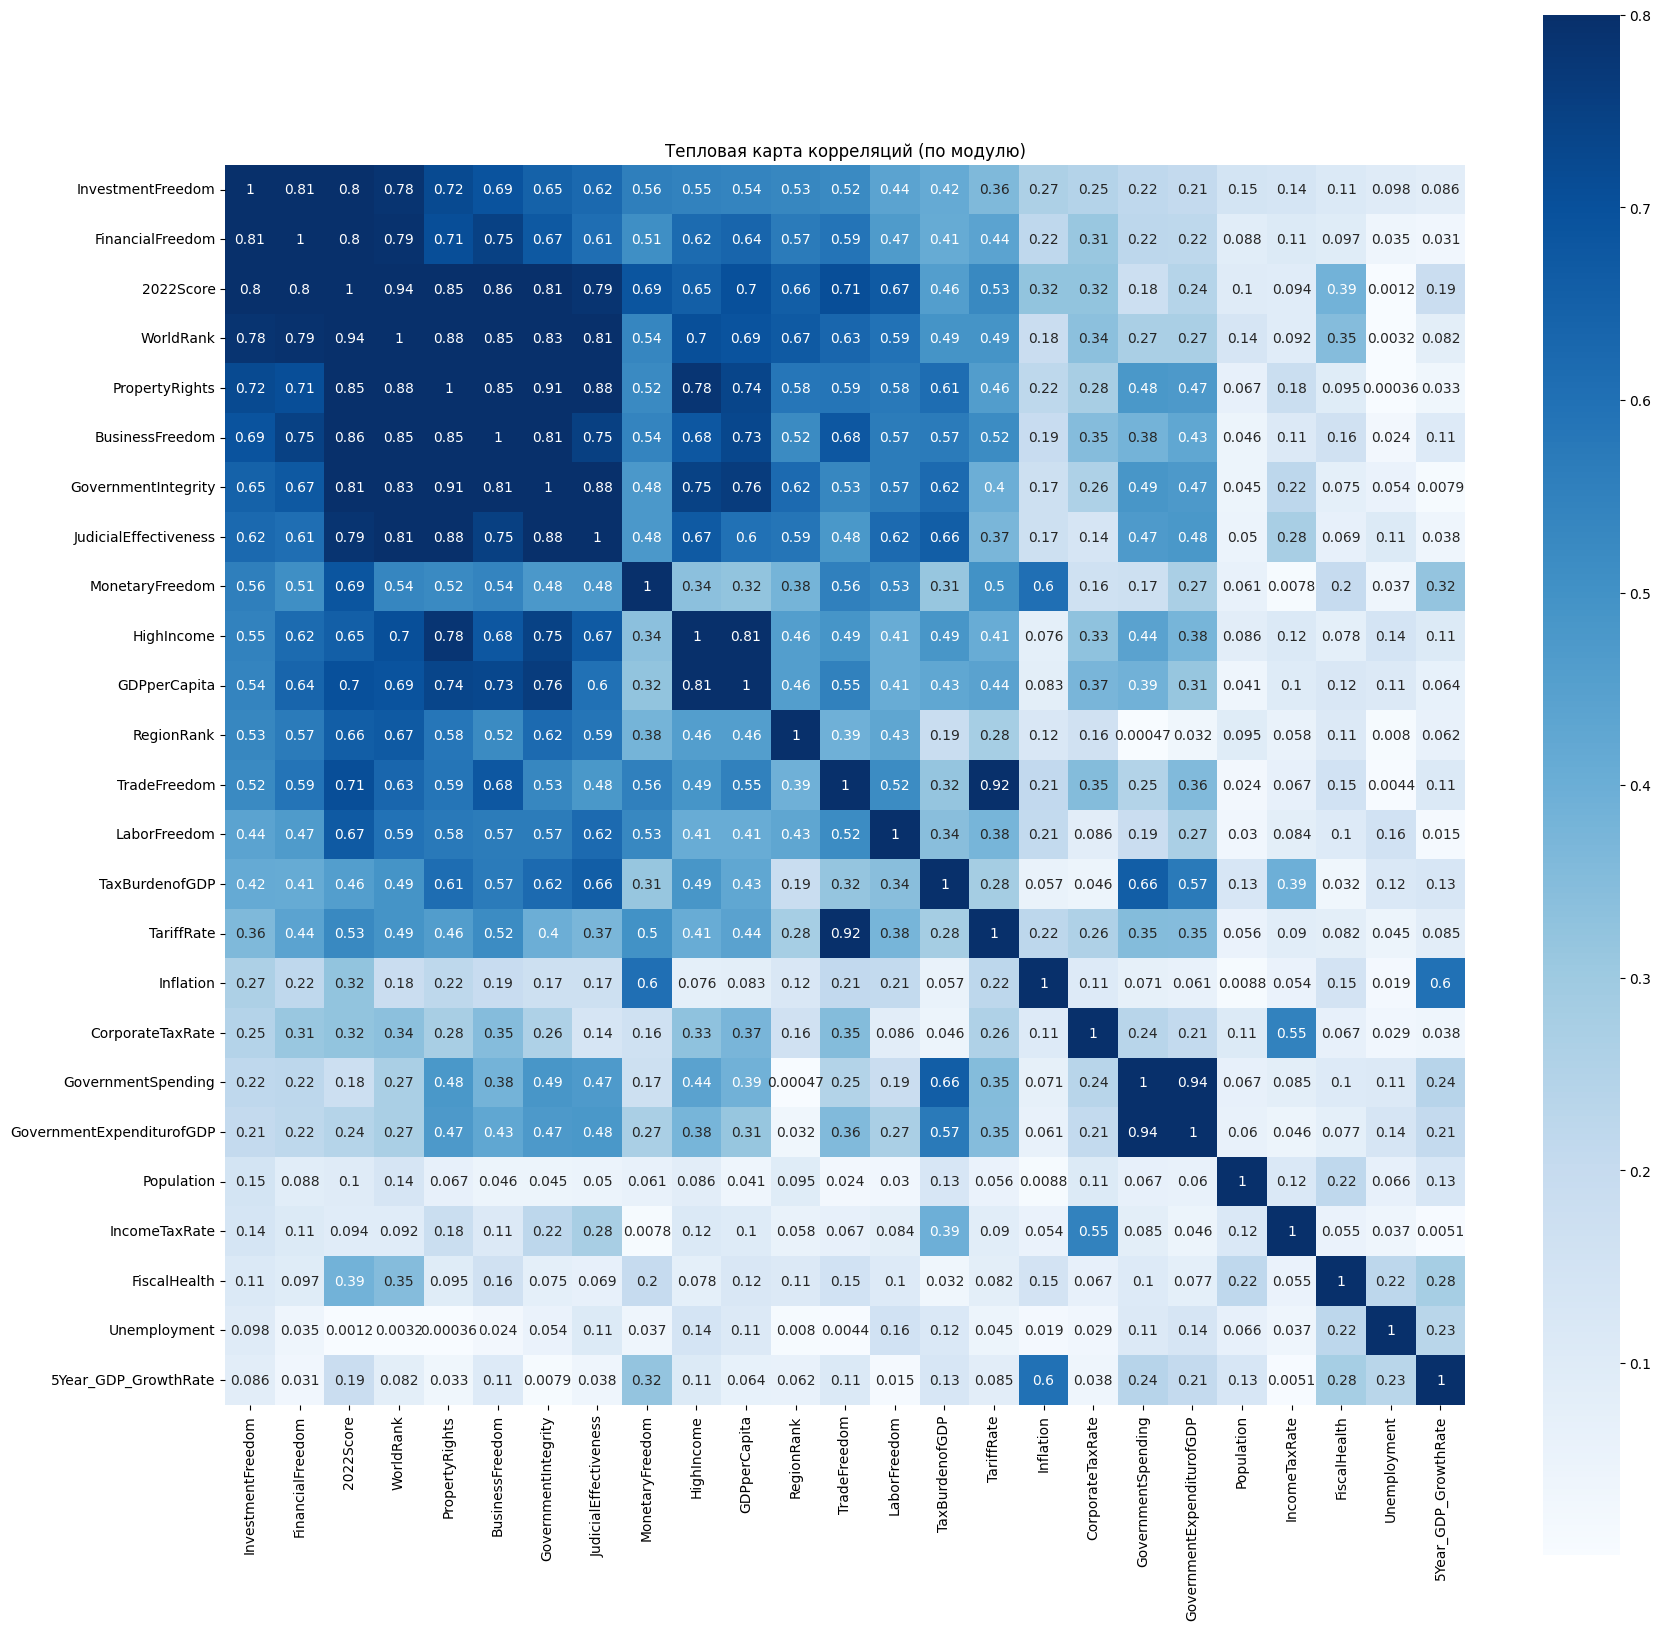

In [22]:
# Все корреляции
corr = df.corr(numeric_only=True)

# Будем рассматривать модули коэффициентов корреляции
corr_abs = corr.abs()

# Определяем топ-20 переменных с наибольшей корреляцией с InvestmentFreedom
top_corr_features = corr_abs['InvestmentFreedom'].nlargest(25).index
top_corr_matrix_abs = corr_abs.loc[top_corr_features, top_corr_features]

# Построение тепловой карты
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr_matrix_abs, annot=True, square=True, cmap='Blues', vmax=0.8)
plt.title('Тепловая карта корреляций (по модулю)')
plt.show()


можно взять такие переменные:
- Population
- FiscalHealth
- GovernmentExpenditurofGDP
- не берём GovernmentSpending
- CorporateTaxRate
- Inflation


In [23]:
# табличку сделаем
cols = ['InvestmentFreedom', 'Population', 'FiscalHealth', 'GovernmentExpenditurofGDP', 'CorporateTaxRate', 'Inflation']
df[cols].corr()
# по взаимным корреляциям всё норм

,InvestmentFreedom,Population,FiscalHealth,GovernmentExpenditurofGDP,CorporateTaxRate,Inflation
InvestmentFreedom,1.000000,-0.146043,0.113597,0.205159,-0.245269,-0.265333
Population,-0.146043,1.000000,-0.218035,-0.060412,0.108621,-0.008834
FiscalHealth,0.113597,-0.218035,1.000000,-0.076623,-0.067267,-0.148299
GovernmentExpenditurofGDP,0.205159,-0.060412,-0.076623,1.000000,-0.207490,-0.061432
CorporateTaxRate,-0.245269,0.108621,-0.067267,-0.207490,1.000000,0.105403
Inflation,-0.265333,-0.008834,-0.148299,-0.061432,0.105403,1.000000


### Выбор алгоритма кластеризации - данных много => k-means

не успель :(
